
# Imports y preprocesamiento


In [1]:
import pandas as pd
import numpy as np

In [6]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
import statsmodels.api as sm

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [42]:
dataset = pd.read_csv('Electric_Production.csv')
dataset.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [43]:
# Establecemos la columna de fechas como formato Datetime

dataset['DATE'] = pd.to_datetime(dataset['DATE'])
dataset.set_index('DATE', inplace=True)
dataset.rename(columns = {'IPG2211A2N':'VALUE'}, inplace = True)

dataset.head()

,VALUE
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='DATE'>

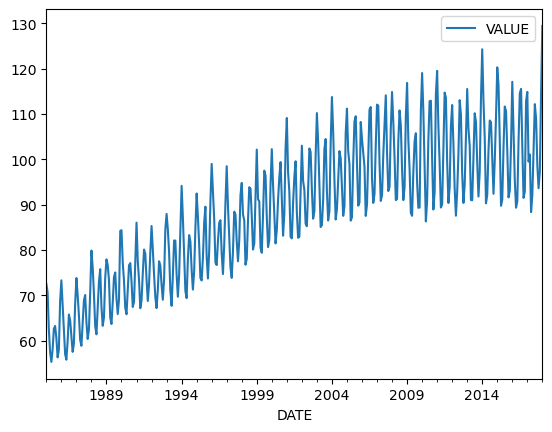

In [44]:
# Visualizamos los datos

dataset.plot()

# Tests de Fuller

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
fuller_test = adfuller(dataset['VALUE'])

In [11]:
fuller_test

(-2.256990350047245,
 0.1862146911658677,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

In [12]:
# Comprobamos si los datos son estacionarios o no mediante el test de fuller analizando el valor de P

def comprobar_valor_p(data):
        test_fuller = adfuller(data)
        print('Valor de P = ' + str(test_fuller[1]))
        if test_fuller[1] <= 0.05:
            print('Rechazar hipótesis nula, los datos son estacionarios')
        else:
            print('No rechazar hipótesis nula, los datos son estacionarios')
            


In [13]:
comprobar_valor_p(dataset['VALUE'])

Valor de P = 0.1862146911658677
No rechazar hipótesis nula, los datos son estacionarios


<Axes: xlabel='DATE'>

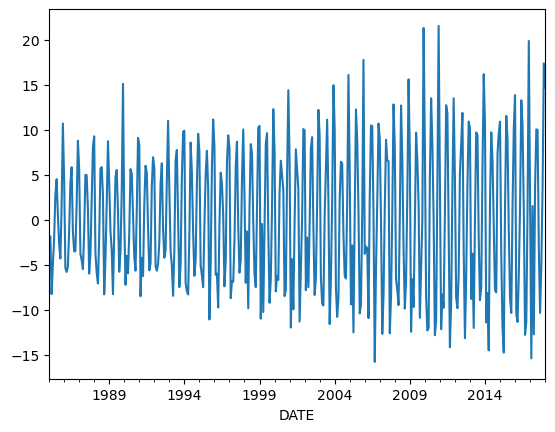

In [14]:
# Realizamos la primera diferenciación

dataset['Dif_1'] = dataset['VALUE'] - dataset['VALUE'].shift(1)
dataset['Dif_1'].plot()

In [15]:
# Realizamos de nuevo el test de fuller sobre la primera diferenciacion

comprobar_valor_p(dataset['Dif_1'].dropna())

Valor de P = 4.0777865655392766e-10
Rechazar hipótesis nula, los datos son estacionarios


<Axes: xlabel='DATE'>

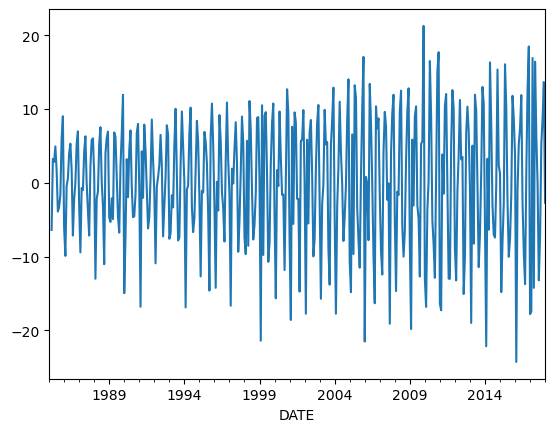

In [16]:
# Los datos siguen siendo estacionarios, así que diferenciamos una segunda vez

dataset['Dif_2'] = dataset['Dif_1'] - dataset['Dif_1'].shift(1)
dataset['Dif_2'].plot()

In [17]:
comprobar_valor_p(dataset['Dif_2'].dropna())

Valor de P = 4.183693747997024e-17
Rechazar hipótesis nula, los datos son estacionarios


<Axes: xlabel='DATE'>

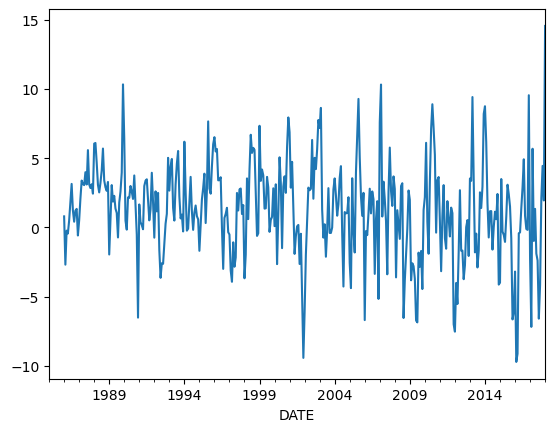

In [18]:
dataset['Dif_Estacional'] = dataset['VALUE'] - dataset['VALUE'].shift(12)
dataset['Dif_Estacional'].plot()

In [19]:
comprobar_valor_p(dataset['Dif_Estacional'].dropna())

Valor de P = 8.812644938089026e-07
Rechazar hipótesis nula, los datos son estacionarios


# Funciones de autocorrelación y autocorrelación parcial

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

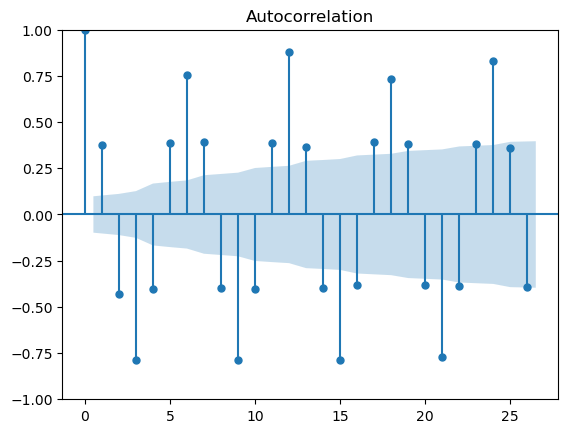

In [21]:
# Gráfico de autocorrelación

dif_1 = plot_acf(dataset['Dif_1'].dropna())

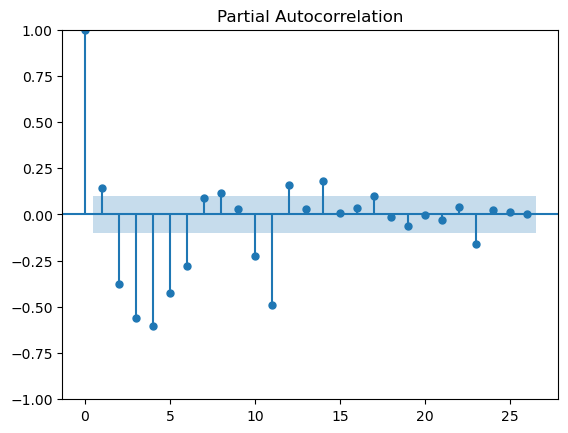

In [22]:
# Gráfico de autocorrelación parcial

sec_diff = plot_pacf(dataset['Dif_2'].dropna())

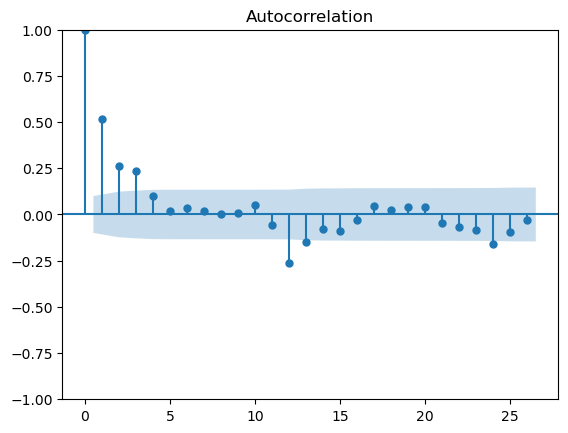

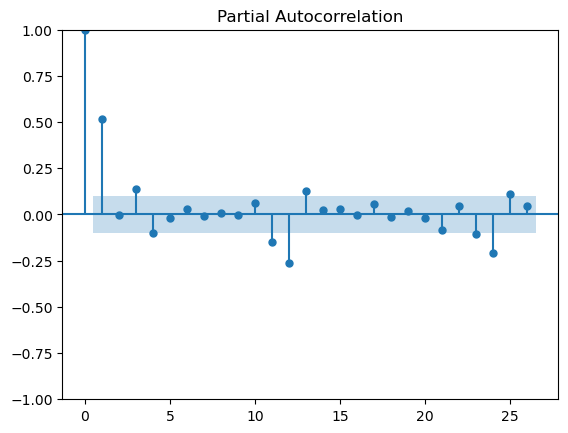

In [23]:
# Gráficos de autocorrelación y autocrrelación parcial de la diferenciación estacional

p1 = plot_acf(dataset['Seasonal_diff'].dropna())
p2 = plot_pacf(dataset['Seasonal_diff'].dropna())

# Modelo SARIMA

In [27]:
# Creamos nuestro modelo inicial

modelo = sm.tsa.statespace.SARIMAX(dataset['VALUE'],order=(0,1,0),seasonal_order=(1,1,1,12))

C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
# Y lo ajustamos

resultados = modelo.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                VALUE   No. Observations:                  397
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -928.856
Date:                              Fri, 12 Apr 2024   AIC                           1863.712
Time:                                      18:29:42   BIC                           1875.564
Sample:                                  01-01-1985   HQIC                          1868.413
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0421      0.058      0.721      0.471      -0.072       0.157
ma.S.L12      -0.7790      0.041    -19.119      0.000      -0.859      -0.699
sigma2         7.1906      0.417     17.245      0.000       6.373       8.008
===================================================================================
Ljung-Box (L1) (Q):                  13.53   Jarque-Bera (JB):                30.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

DATE
1985-01-01    72.505200
1985-02-01    -1.833200
1985-03-01    -8.221800
1985-04-01    -4.978800
1985-05-01    -2.156300
                ...    
2017-09-01     0.529986
2017-10-01     4.057873
2017-11-01     0.690663
2017-12-01     2.477696
2018-01-01     6.953534
Length: 397, dtype: float64

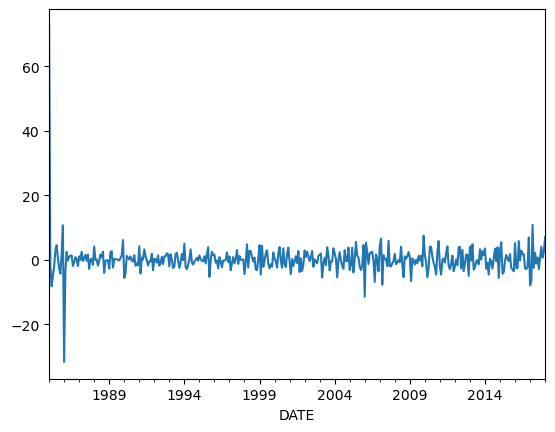

In [29]:
# Analizamos valores residuales

resultados.resid.plot()

resultados.resid

<Axes: ylabel='Density'>

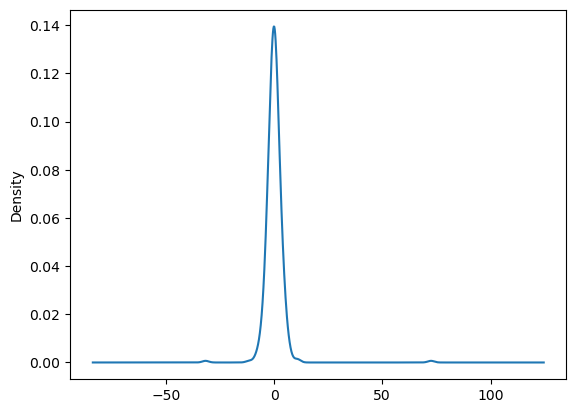

In [30]:
# Distribución de errores en valores residuales

resultados.resid.plot(kind='kde')

# Predicciones iniciales

<Axes: xlabel='DATE'>

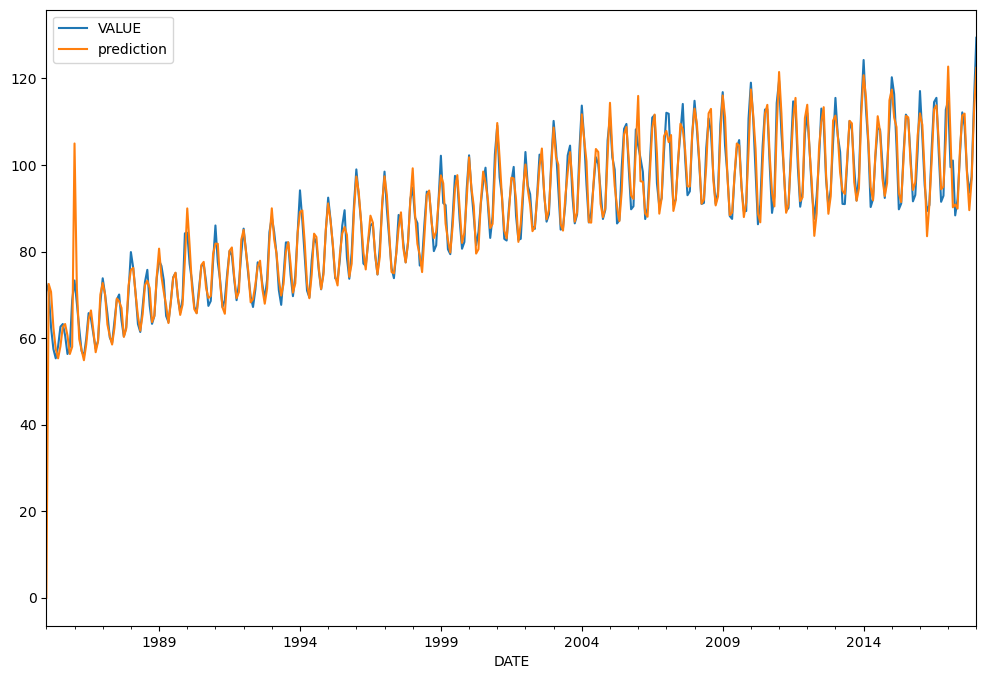

In [31]:
# Evaluando predicciones para las que tenemos datos (presentes)

dataset['prediction'] = resultados.predict()
dataset[['VALUE','prediction']].plot(figsize=(12,8))

In [32]:
# Predicciones a futuro

# Añadimos nuevos elementos temporales
from pandas.tseries.offsets import DateOffset
fechas_adicionales = [dataset.index[-1] + DateOffset(months=m) for m in range (1,24)]

dataset_prediccion = pd.DataFrame(index=fechas_adicionales, columns=dataset.columns)
dataset_prediccion.head()

,VALUE,Dif_1,Dif_2,Dif_Estacional,prediction
2018-02-01,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN
2018-06-01,NaN,NaN,NaN,NaN,NaN


In [33]:
dataset_final = pd.concat([dataset, dataset_prediccion])

<Axes: >

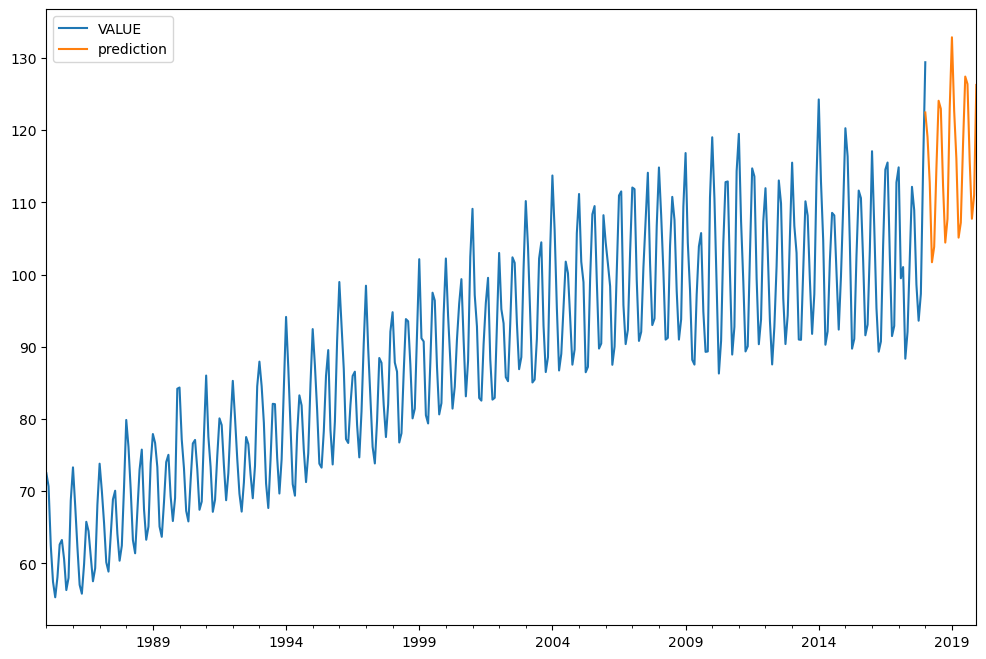

In [34]:
dataset_final['prediction'] = resultados.predict(start=396, end=430)
dataset_final[['VALUE','prediction']].plot(figsize=(12,8))

Determinamos los mejores valores iniciales para d Y D

In [26]:
# Realizamos la prueba con auto_arima para encontrar buenos valores iniciales para D y d

from pmdarima import auto_arima

arima_model = auto_arima(dataset['VALUE'], seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)

D_value = arima_model.order[1]  # Seasonal differencing (D)
d_value = arima_model.order[2]  # Non-seasonal differencing (d)

# Output: 
# Best model:  ARIMA(0,1,4)(2,0,2)[12] 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1953.873, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2750.050, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2401.309, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2748.185, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1955.693, Time=2.59 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2015.881, Time=2.06 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1866.764, Time=0.96 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=2265.648, T

In [25]:
print('Mejor valor para D: ', D_value)
print('Mejor valor para d: ', d_value)

# Output:
# Mejor valor para D:  1
# Mejor valor para d:  2

Mejor valor para D:  1
Mejor valor para d:  2


In [4]:
# Definimos los rangos de cada valor SARIMA

p_values = range(0, 8)  # Orden de modelo Auto-Regresivo (AR)
d_values = range(1, 4)  # Orden de diferenciación - Según las instrucciones, sólo podrá tener un valor por encima o por debajo del obtenido
q_values = range(0, 8)  # Orden de la Media Móvil (Moving Average)
P_values = range(0, 4)  # Orden de la Auto-Regresioin Estacional (Seasonal Auto Regression)
D_values = range(0, 3)  # Orden de la diferenciación Estacional
Q_values = range(0, 8)  # Orden de la Media Móvil Estacional
s_values = [12]  # Periodo estacional (12 meses por año)

In [7]:
# Generamos las soluciones, es decir, las posibles combinaciones de parámetros

combinaciones_param = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

print(len(combinaciones_param))

18432


Establecemos los valores iniciales de d y D acorde con la prueba realizada anteriormente
Los valores de p y q los establecemos observando los gráficos de autocorrelación y autocorrelación parcial; después de cruzar
el intervalo de confianza superior, vemos un declive notable después del primer lag. Ergo, p y q = 1.
Del mismo modo establecemos los valores de P y Q, en este caso con los gráficos de autocorrelación y autocorrelación parcial 
estacionales. Del mismo modo, P y Q = 1.

In [39]:
parametros_iniciales = [1, 2, 1, 1, 1, 4]

                       #p, d, q, P, D, Q


# Simulated annealing


In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError

# Dividimos los datos en entrenamiento y validación
val_size = 50

train_data = dataset[:-val_size]
val_data = dataset[-val_size:]

# Definimos la función de error (RMSE)
def calculate_rmse(params):
    try:
        # Se ajusta el modelo según los parámetros
        modelo = SARIMAX(train_data, order=(params[0], params[1], params[2]), 
                        seasonal_order=(params[3], params[4], params[5], 12))
        modelo_fit = modelo.fit(disp=False)
        predicciones = modelo_fit.predict(len(train_data), len(dataset)-1)
        
        # Se define el RMSE
        rmse = np.sqrt(mean_squared_error(val_data, predicciones))
    except (ValueError, LinAlgError):
        # Si el modelo no puede ser ajustado, devuelve un error elevado
        rmse = 1e10
    return rmse

# Definimos la función que establece el criterio de aceptación
def probabilidad_aceptacion(coste_antiguo, coste_nuevo, temp):
    return np.exp((coste_antiguo - coste_nuevo) / temp)

# Definimos el algoritmo de simulated annealing
def simulated_annealing(estado_inicial, funcion_coste, temperatura=10, alfa=0.9, num_iteraciones=30):
    estado_actual = estado_inicial
    coste_actual = funcion_coste(estado_actual)
    for i in range(num_iteraciones):
        print("Nº Iteración: " + str(i+1))
        estado_candidato = estado_actual + np.random.uniform(-1, 1, size=len(estado_actual))
        # Los límites de los valores de los parámetros, según las especificaciones
        estado_candidato = np.clip(estado_candidato, [0, 1, 0, 0, 0, 0], [8, 3, 8, 3, 2, 8])
        
        # Lo restringimos a enteros
        estado_candidato = np.round(estado_candidato).astype(int)
        coste_candidato = funcion_coste(estado_candidato)
        ap = probabilidad_aceptacion(coste_actual, coste_candidato, temperatura)
        if ap > np.random.uniform():
            estado_actual, coste_actual = estado_candidato, coste_candidato
        temperatura *= alfa
    return estado_actual, coste_actual


# Run the simulated annealing algorithm
temperatura = 10
ratio_enfriamiento = 0.9
numero_iteraciones = 30

estado_final, coste_final = simulated_annealing(parametros_iniciales, 
                                              calculate_rmse, 
                                              temperatura,
                                              ratio_enfriamiento,
                                              numero_iteraciones)
print(f"Parámetros finales: {estado_final}, RMSE final: {coste_final}")


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 1


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Nº Iteración: 2


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 3


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 4


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 5


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 6


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 7


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 8


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 9


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\santi\.conda\envs\tf-directml\lib\site-pac

Nº Iteración: 10


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\santi\.conda\envs\tf-directml\lib\site-pac

Nº Iteración: 11


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Nº Iteración: 12


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 13


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

Nº Iteración: 14


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 15


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 16


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 17


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 18


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodel

Nº Iteración: 19


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 20


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 21


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

Nº Iteración: 22


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 23


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 24


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nº Iteración: 25


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 26


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 27


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 28


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\

Nº Iteración: 29


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Nº Iteración: 30


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parámetros finales: [5 1 2 3 1 0], RMSE final: 3.4730860327955284


In [ ]:
# Output: Parámetros finales: [5 1 2 3 1 0], RMSE final: 3.4730860327955284

El resultado final tiene un valor de error satisfactorio.

In [50]:
# Ajustamos el modelo final con los parámetros obtenidos por el algoritmo simulated annealing

modelo_final = sm.tsa.statespace.SARIMAX(dataset['VALUE'],order=(5,1,2),seasonal_order=(3,1,0,12))
resultados = modelo_final.fit()
resultados.summary()

C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               VALUE   No. Observations:                  397
Model:             SARIMAX(5, 1, 2)x(3, 1, [], 12)   Log Likelihood                -883.982
Date:                             Fri, 12 Apr 2024   AIC                           1789.963
Time:                                     18:43:58   BIC                           1833.421
Sample:                                 01-01-1985   HQIC                          1807.200
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3795      0.096     -3.944      0.000      -0.568      -0.191
ar.L2          0.3917      0.070      5.592      0.000       0.254       0.529
ar.L3          0.0448      0.065      0.685      0.493      -0.083       0.173
ar.L4          0.0707      0.062      1.146      0.252      -0.050       0.192
ar.L5         -0.1083      0.057     -1.912      0.056      -0.219       0.003
ma.L1         -0.0366      0.079     -0.464      0.643      -0.191       0.118
ma.L2         -0.8904      0.078    -11.431      0.000      -1.043      -0.738
ar.S.L12      -0.6383      0.043    -14.945      0.000      -0.722      -0.555
ar.S.L24      -0.5589      0.053    -10.631      0.000      -0.662      -0.456
ar.S.L36      -0.3024      0.048     -6.320      0.000      -0.396      -0.209
sigma2         5.6698      0.349     16.232      0.000       4.985       6.354
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.58
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


# Grafo


In [86]:
import itertools

# Creamos el grafo con NetworkX
G = nx.Graph()

# Añadimos los nodos, uno por cada solución posible
for param in combinaciones_param:
    G.add_node(param)

# Añadimos los arcos entre soluciones vecinas
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 != node2 and sum(abs(a-b) for a, b in zip(node1, node2)) == 1:
            G.add_edge(node1, node2)


In [ ]:
print(G.nodes)

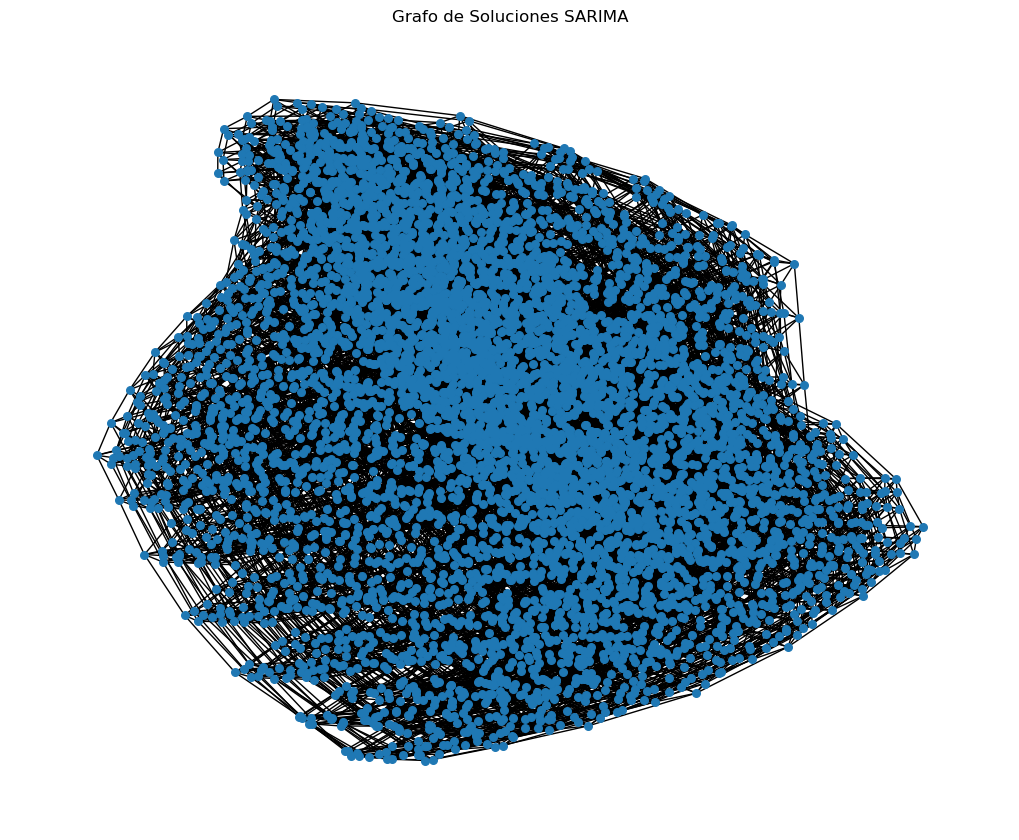

In [72]:
# Visualizamos el grafo

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=30)
plt.title("Grafo de Soluciones SARIMA")
plt.show()

In [2]:
# Computamos la cercanía de centralidad de los nodos

cercania = nx.closeness_centrality(G)
nodos_baja_cercania = [node for node, centralidad in cercania.items() if centralidad < 0.1]

print(nodos_baja_cercania)

In [93]:
# Función para devolver los vecinos de un nodo. Si el booleano 'unique' es Falso, devolvemos un vecino, si no, devolvemos todos.

def get_vecino(G, node, unique=True):  
    vecinos = list(G.neighbors(node))
    
    # Si el nodo tiene vecinos
    if vecinos:
        if unique:
            # Devolvemos el primer vecino
            return vecinos[0]
        else:
            # Devolvemos todos los vecinos
            return vecinos
    else:
        return None

In [3]:
print(get_vecino(G, (5, 1, 2, 3, 1, 0, 12)))